# The Calculation of Interparticle Distance for Direct Neighbors of Randomly Dispersed Particles

## Peter Defnet
*February 21, 2021*


The goal of this project is to find the interparticle spacing for an image containing thousands of randomly dispersed nanoparticles. 

The workflow is divided into 2 parts: 
1. Finding the (x,y) coordinates of the nanoparticle centers. 
2. Determining which particles are direct neighbors, and calculating their euclidean distance. 

We first import required packages.

In [1]:
#Import Packages
import cv2
from skimage.color import rgb2gray
from skimage.feature import blob_log
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from math import hypot
import scipy.spatial
import warnings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 #Changes DPI of in-line figures.

Then load the desired image given the filepath. 

In [2]:
file_extension = "C:/Users/Peter/Desktop/Robin's Images/"
filename_load = '200nm Au NP 20x 0.50 NA collecting obj - 2.2 Cropped; larger.tif' 
filepath = file_extension + filename_load 

image = cv2.imread(filepath, 0) #Defined for later use. The '(,0)' makes the image grayscale. 

Here we plot the original image for reference, with the original colors maintained. 
The image was taken using a darkfield microscope. 

In [3]:
def plot_original_image(filepath):
    """Plot full-color version of original image"""
    plt.imshow(cv2.imread(filepath))
    plt.title("Original Image")
    
    plt.show()

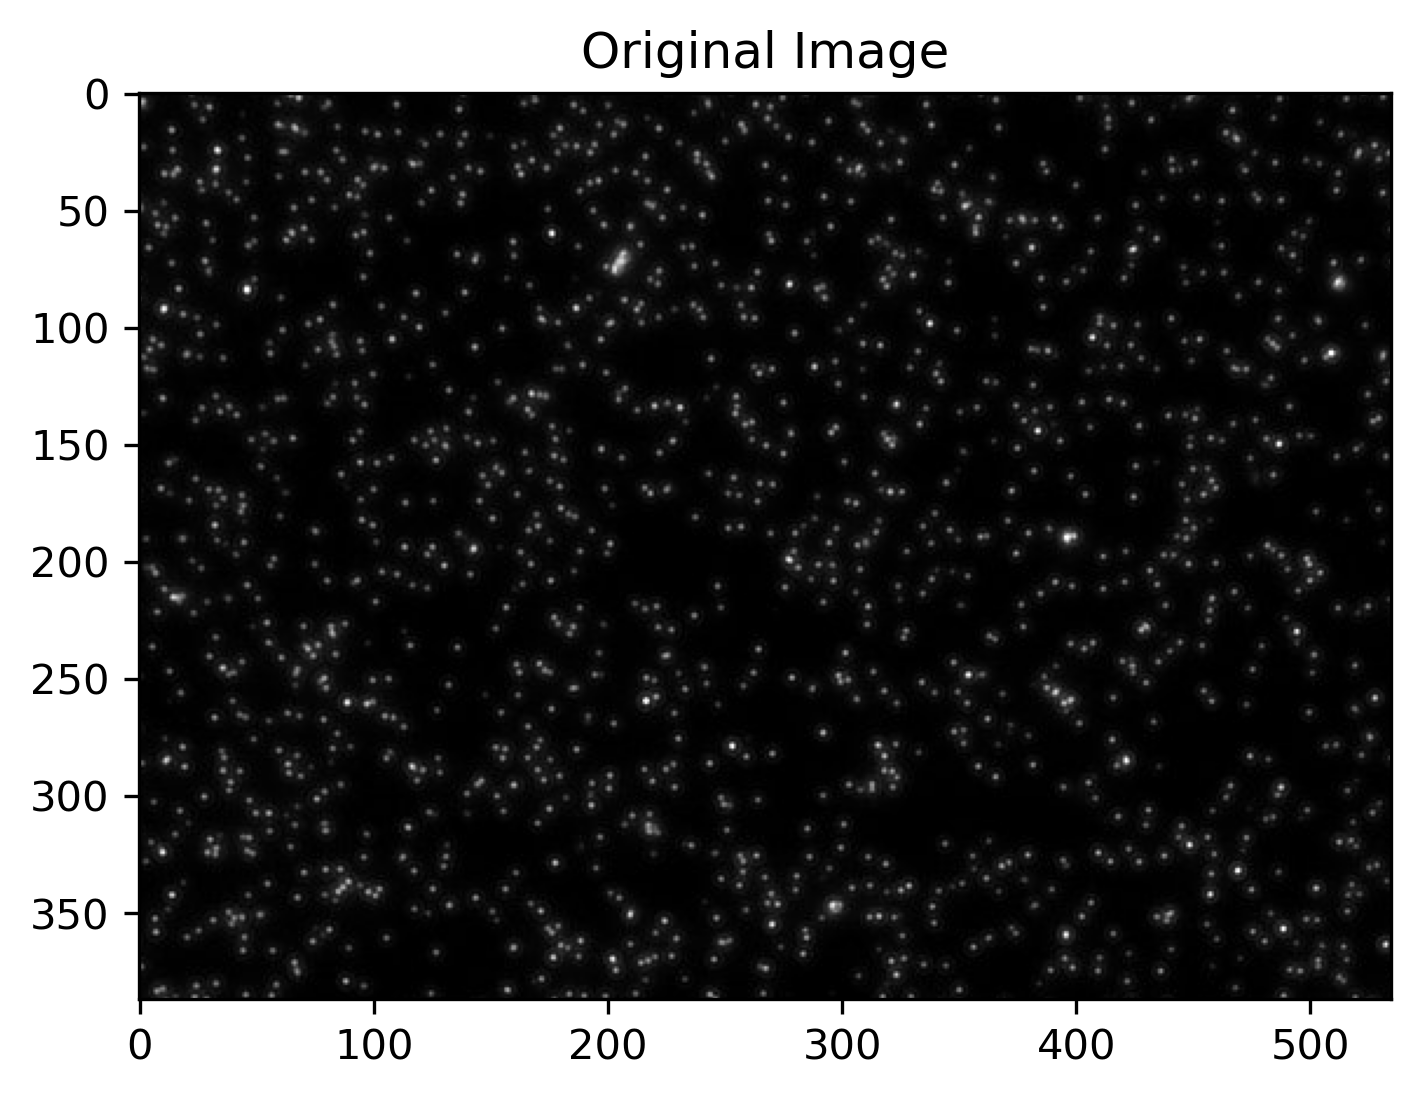

In [4]:
#Plot input image with original colors
plot_original_image(filepath)

The coordinates of nanoparticle centers are found using a 'Laplacian of Gaussian' (LOG) spatial filter. The LOG finds local minima of the second derivative, while considering the image as a topological map. More information about how the LOG works can be found here: 
https://automaticaddison.com/how-the-laplacian-of-gaussian-filter-works/


We find 'laplace_coords' using a built-in function from skimage.feature called 'blob_log', which outputs the (x,y) coordinates and the standard deviation (sigma) of the gaussian kernel. Sigma is converted to radius with an approximation of r = sqrt(2) * sigma.  


*Note that the input parameters for blobs_log() may need to be adjusted for new images. See documentation for details. 
https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log


In [5]:
def extract_LOG_coordinates(image): 
    """Extracts Coordinates of Nanoparticle Centers."""
    
    with warnings.catch_warnings(): #Ignore warnings given by 'blob_log'
        warnings.simplefilter("ignore")
        
        image_gray = rgb2gray(image)
    
        laplace_coords = blob_log(image_gray, min_sigma = 1, max_sigma=50, num_sigma=50, threshold=0.06, overlap = 0.1)
        laplace_coords[:, 2] = laplace_coords[:, 2] * sqrt(2) # Compute radii in the 3rd column.


    return laplace_coords


In [6]:
# Extract Coordinates from where NP's are. 
laplace_coords = extract_LOG_coordinates(image) 

Next we visualize the identified the identified coordinates by overlaying yellow circles with defined radii on the original grayscale image. We plot the original image (on left) and overlaid coordinates (on right) for direct comparison. 

A few instances occur where tightly clustered particles are not distinguishable by LOG and are labeled as a single large cluster. It is important to minimize these occurances by adjusting the input parameters of blobs_log in the 'extract_LOG_coordinates' function above. 

In [7]:
def plot_overlaid_coordinates(image, laplace_coords):
    """Plots Original Image vs. Original Image with overlaid locations of nanoparticles, identified by laplace_coords."""
    
    #Plot Subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
    
    ax1.imshow(image)
    ax2.imshow(image)
    
    ax1.set_title("Original")    
    ax2.set_title("Points ID'd by Laplacian of Gaussian")
    
    for blob in laplace_coords:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="yellow", linewidth=1, fill=False)
        ax2.add_patch(c)
    
    plt.tight_layout()
    plt.show()

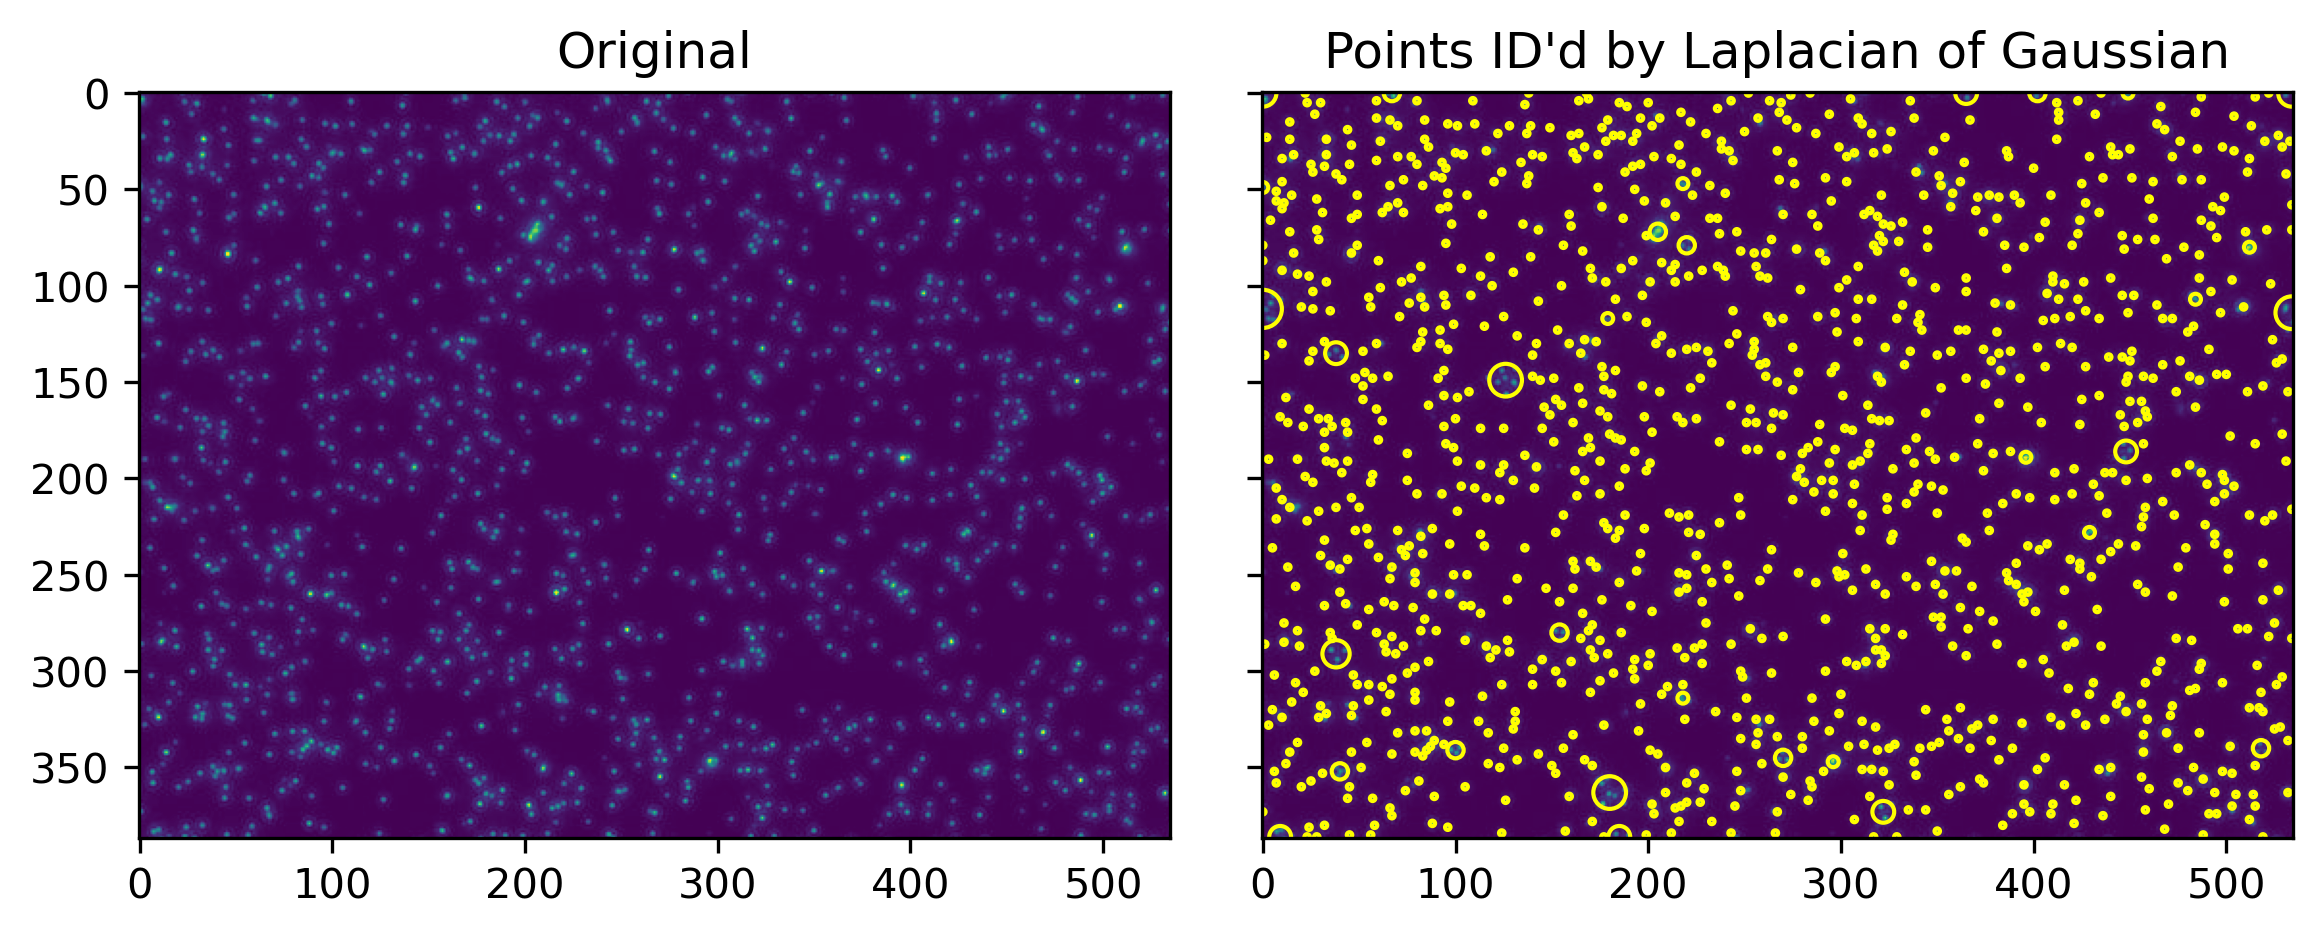

In [8]:
# Visualize Coords overlaid on image. 
plot_overlaid_coordinates(image, laplace_coords) #Plot All Identified Coordinates


We now have the (x,y) coordinates of each nanoparticle's center, defined in 'laplace_coords' !

We next must identify which particles are considered 'direct neighbors'. This is a challenging task if we only use Euclidean distance, since tight clusters of closely-spaced particles may exist close to a given center, where particles 'behind' others may outrank true neighbors further away. 

A 'direct neighbor' is a particle that has the most direct path to a given particle, without overlapping the direct path of another. 

Direct neighbors are found using 'Delaunay Tessellation', which draws triangles between adjacent points, and maximizes the minimum angles. Interestingly, same method is commonly used for finite element simulation. 

Using a built-in implementation of Delaunay Tessellation in scipy.spatial, we plot all connected points in 'plot_connected_delaunay', and separately find the indices of direct neighbors with 'find_neighbors'.

In [9]:
def plot_connected_delaunay(laplace_coords):
    """Plots Delaunay Tessellation of all laplace_coords. """
    dela = scipy.spatial.Delaunay
    points = np.array(column(laplace_coords, [0 , 1])) #note np.array object is used for plt.triplot()
    triang = dela(points) #
    
    
    #Plot Tessellation.
    plt.triplot(points[:,0], points[:,1], triang.simplices, lw = 0.5, alpha = 0.6)
    plt.plot(points[:,0], points[:,1], 'o', markersize = 0.5)
    
    plt.title("Delaunay Tessellation on All Points", fontsize = 11)
    
    plt.show()


'column' is a helper function used to select a given column of an array object. 

In [10]:
def column(matrix, i): #select i columns of array.
    """Select ith column of np.array object"""
    return [row[i] for row in matrix]


Here, we plot the Delaunay Tessellation for the entire input image. 

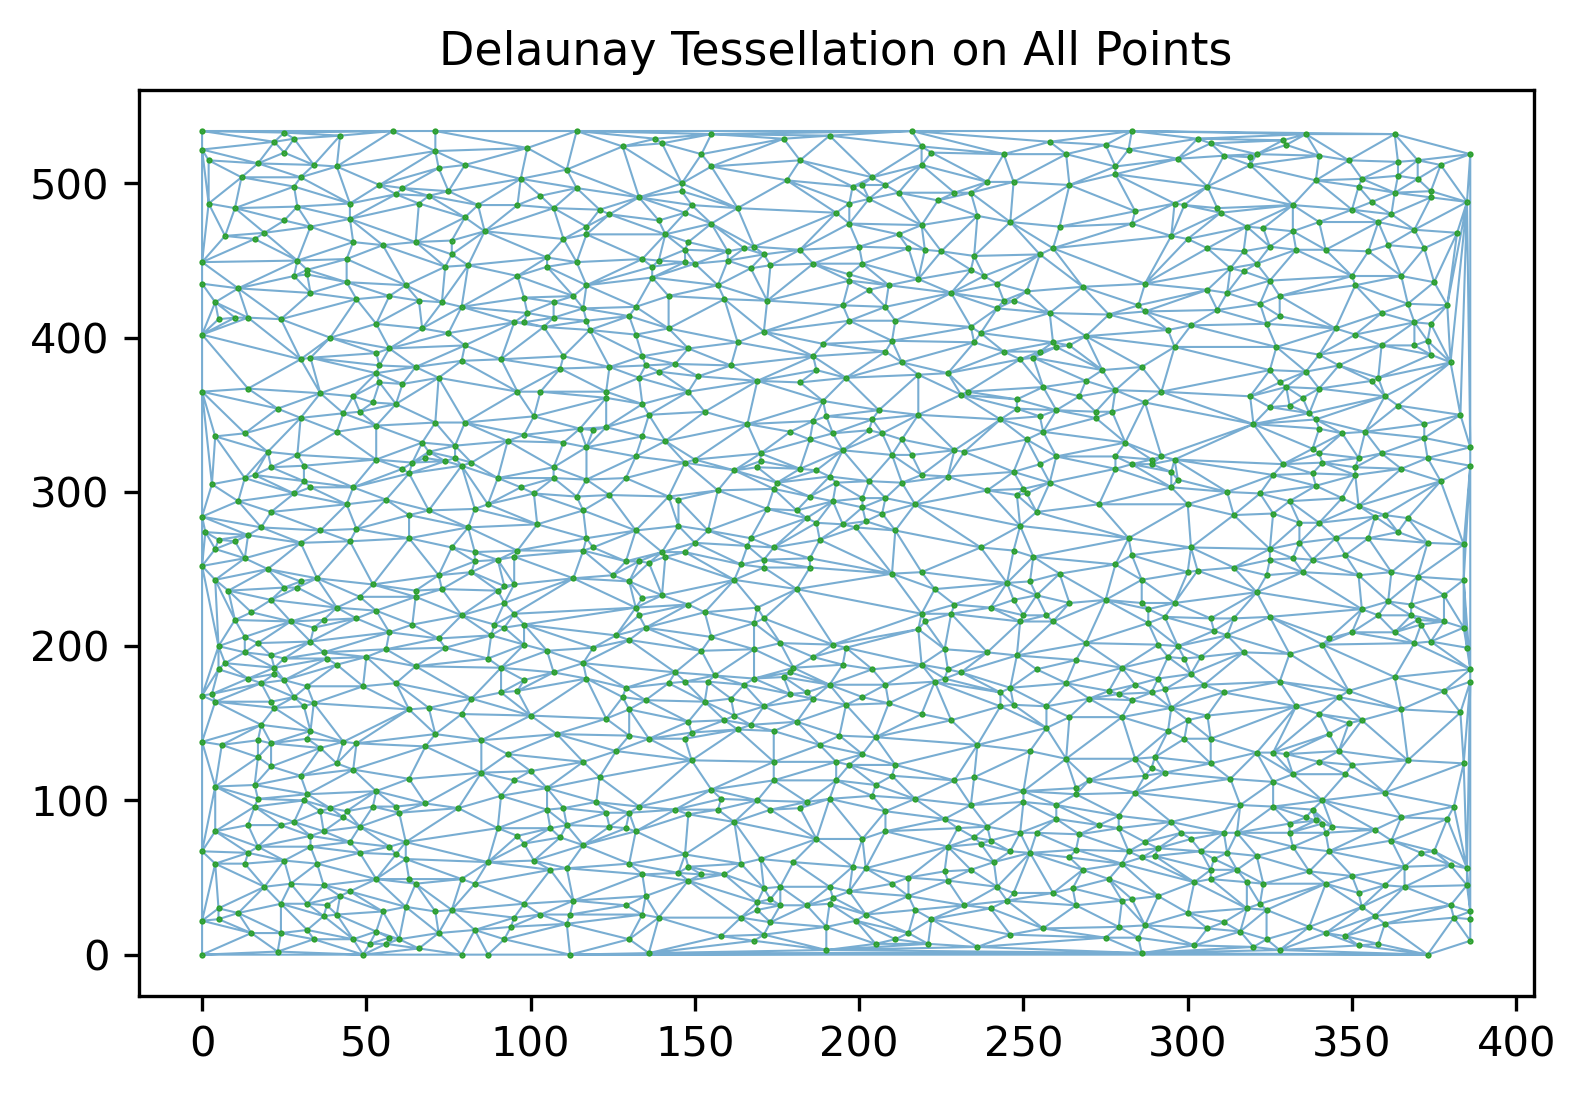

In [11]:
# Visualize Delaunay Tessellation at all laplace_coords.
plot_connected_delaunay(laplace_coords)


The function 'find_neighbors' outputs the indices of direct neighbors in the delaunay tessellation. 

The 'find_neighbors' function was reused from Stack Overflow: 
https://stackoverflow.com/questions/12374781/how-to-find-all-neighbors-of-a-given-point-in-a-delaunay-triangulation-using-sci

In [12]:
def find_neighbors(pindex, triang): #pindex = point index.
    """Finds direct neighbors of Delaunay Tessellation.
    pindex: int : point index of 'laplace_coords', for which neighbors are found relative to. 
    triang: Delaunay object containing info on which points are vertices of connecting triangles
    """
    neighbors = []
    for simplex in triang.vertices:
        if pindex in simplex:
            neighbors.extend([simplex[i] for i in range(len(simplex)) if simplex[i] != pindex])
            '''
            this is a one liner for if a simplex contains the point we`re interested in,
            extend the neighbors list by appending all the *other* point indices in the simplex
            '''
    #now we just have to strip out all the dulicate indices and return the neighbors list:
    return list(set(neighbors))
 

Here we plot 6 examples of a given point and its identified neighbors. 

On the left, we overlay all 'laplace_coords' with a faint yellow color. The identified point is in red, and its direct neighbors in bright yellow. 

On the right, we plot the same red center point and bright yellow neighbors overlaid on the original grayscale image. 

In [13]:
def plot_direct_neighbors(image, laplace_coords, plot_examples = 6):
    """Plots Original Image with overlaid central NP's (red) and direct neighbors (yellow). 
        Intended to show effectiveness of identifying direct neighbors with Delaunay tessellation.
        """
        
    #Re-instantiate Delaunay Tessellation
    dela = scipy.spatial.Delaunay
    triang = dela(column(laplace_coords, [0 , 1])) #select only x,y columns. 

    
    #Plot Delaunay neighbor examples: 
    #Select the # of examples to plot defined with 'plot_examples'
    indexes = list(range(int(0.25 * len(laplace_coords)), int(0.75 * len(laplace_coords)), int(0.5 * len(laplace_coords)) // (plot_examples-1)))
    
    for index in indexes: #else, cycle through range(len(laplace_coords)) to plot all neighbors. 
    
        center = laplace_coords[index]  
        neighbors = laplace_coords[find_neighbors(index, triang)]
        
        #Plot center in red, and direct neighbors in yellow. 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
        
        ax1.imshow(image)
        ax2.imshow(image)
        
        ax1.set_title("Neighbors Overlaid on LOG", fontsize = 11)    
        ax2.set_title("Neighbors Overlaid on Grayscale", fontsize = 11)
        
        
        #Left Plot (ax1)
        
        #Plot all non-neighbors in faint yellow color. (Left Plot)
        laplace_no_neighbor = np.delete(laplace_coords, find_neighbors(index, triang), 0)
        for blob in laplace_no_neighbor: #plot all circles
            y, x, r = blob
            c = plt.Circle((x, y), r, color="yellow", linewidth=1, fill=False, alpha = 0.3)
            ax1.add_patch(c) 
        
        #Plot neighbors in strong yellow color. (Left Plot)
        for blob in neighbors:
            y, x, r = blob
            c = plt.Circle((x, y), r, color="yellow", linewidth=1, fill=False)
            ax1.add_patch(c)
        
        #Plot central point in red. (left Plot)
        y2, x2, r2 = center
        c2 = plt.Circle((x2, y2), r2, color="red", linewidth=1, fill=False)
        ax1.add_patch(c2)
        
        
        
        #Right Plot (ax2)
        
        #Plot central point in red. (Right Plot)
        y2, x2, r2 = center
        c2 = plt.Circle((x2, y2), r2, color="red", linewidth=1, fill=False)
        ax2.add_patch(c2)
        
        #Plot direct neighbors in yellow (Right Plot)
        for blob in neighbors:
            y, x, r = blob
            c = plt.Circle((x, y), r, color="yellow", linewidth=1, fill=False)
            ax2.add_patch(c)
        
        

        plt.tight_layout()
        plt.show()
        


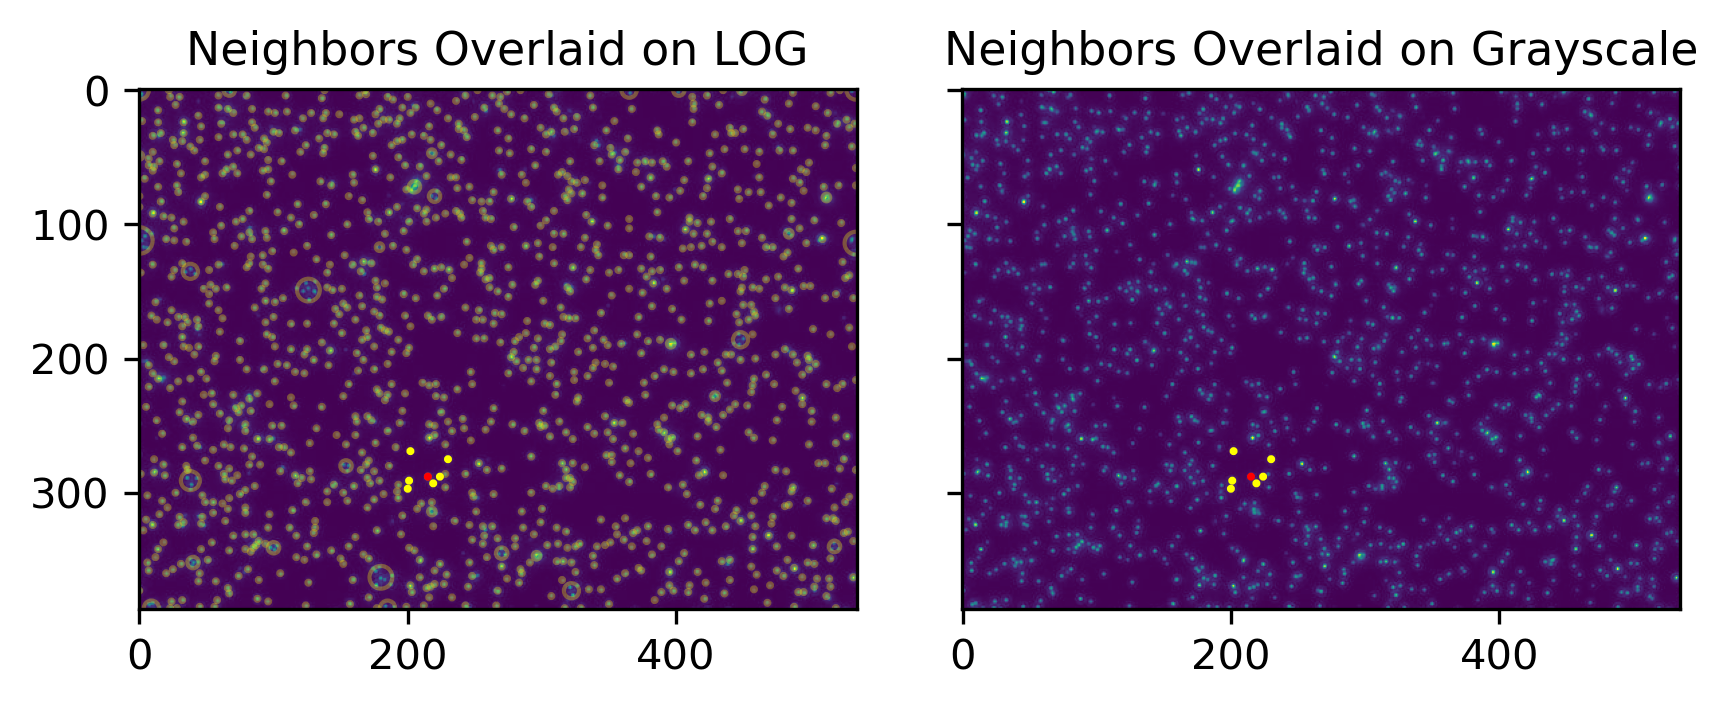

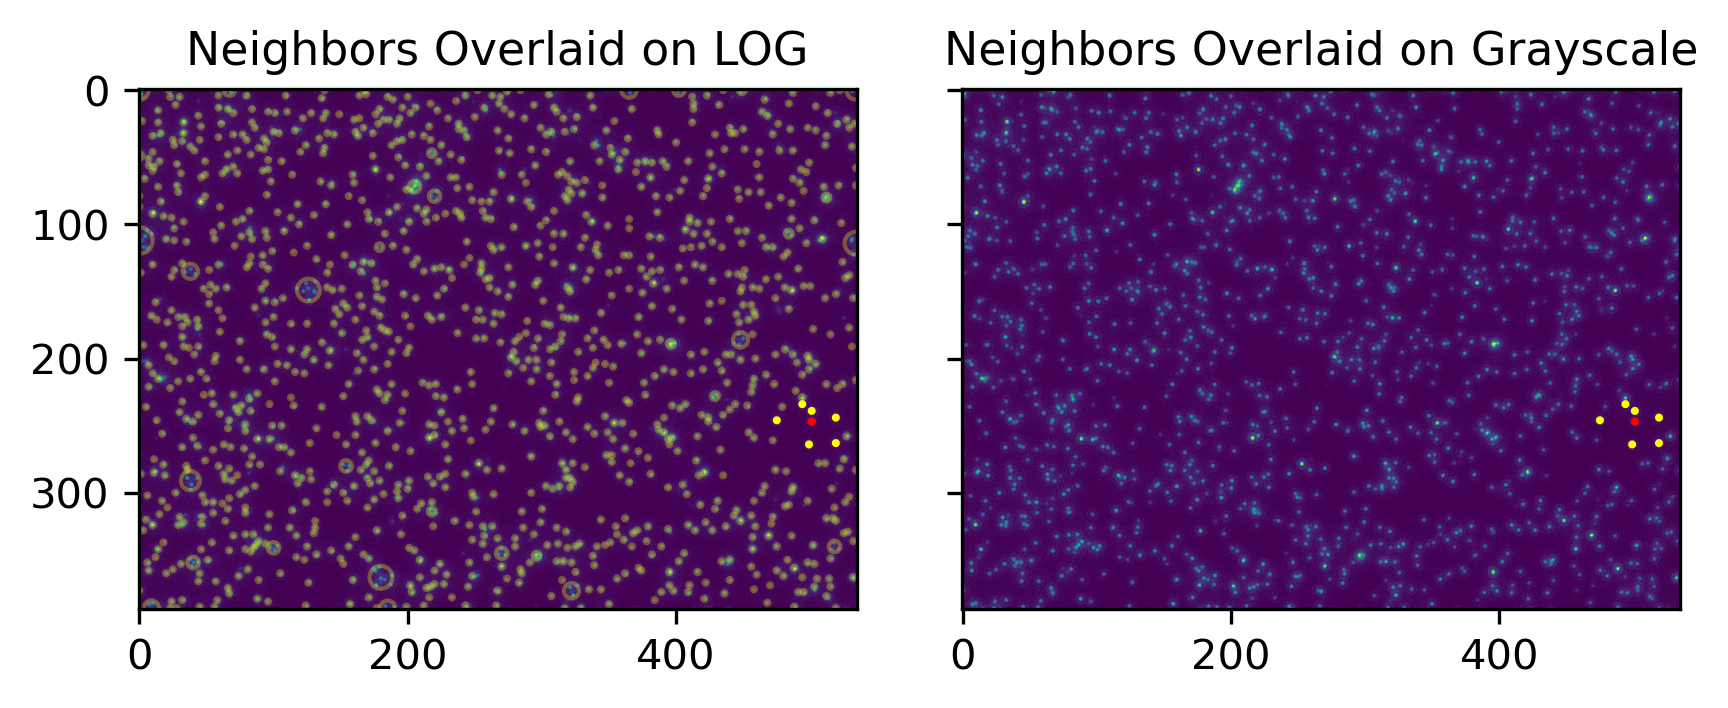

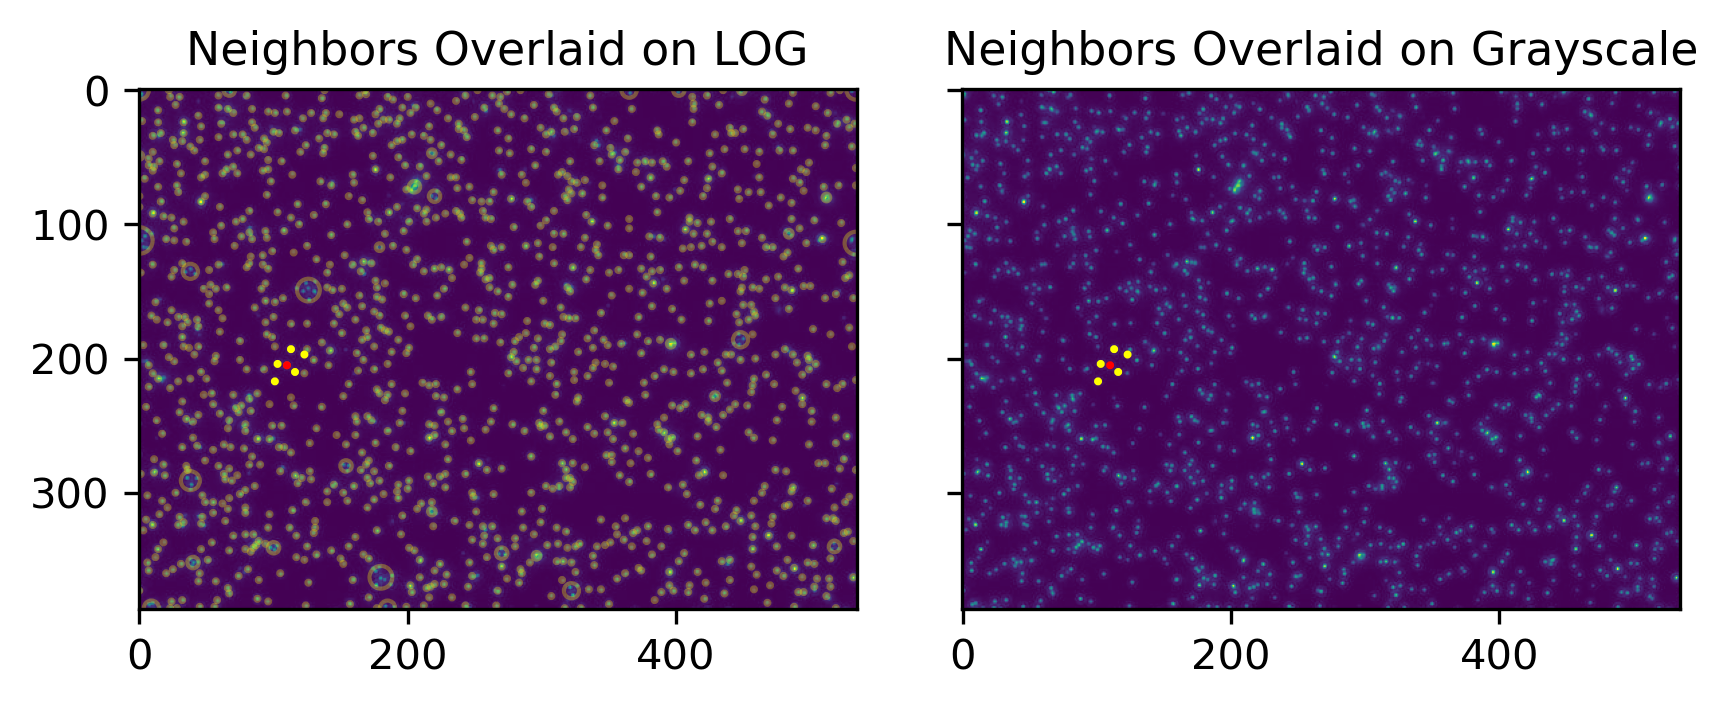

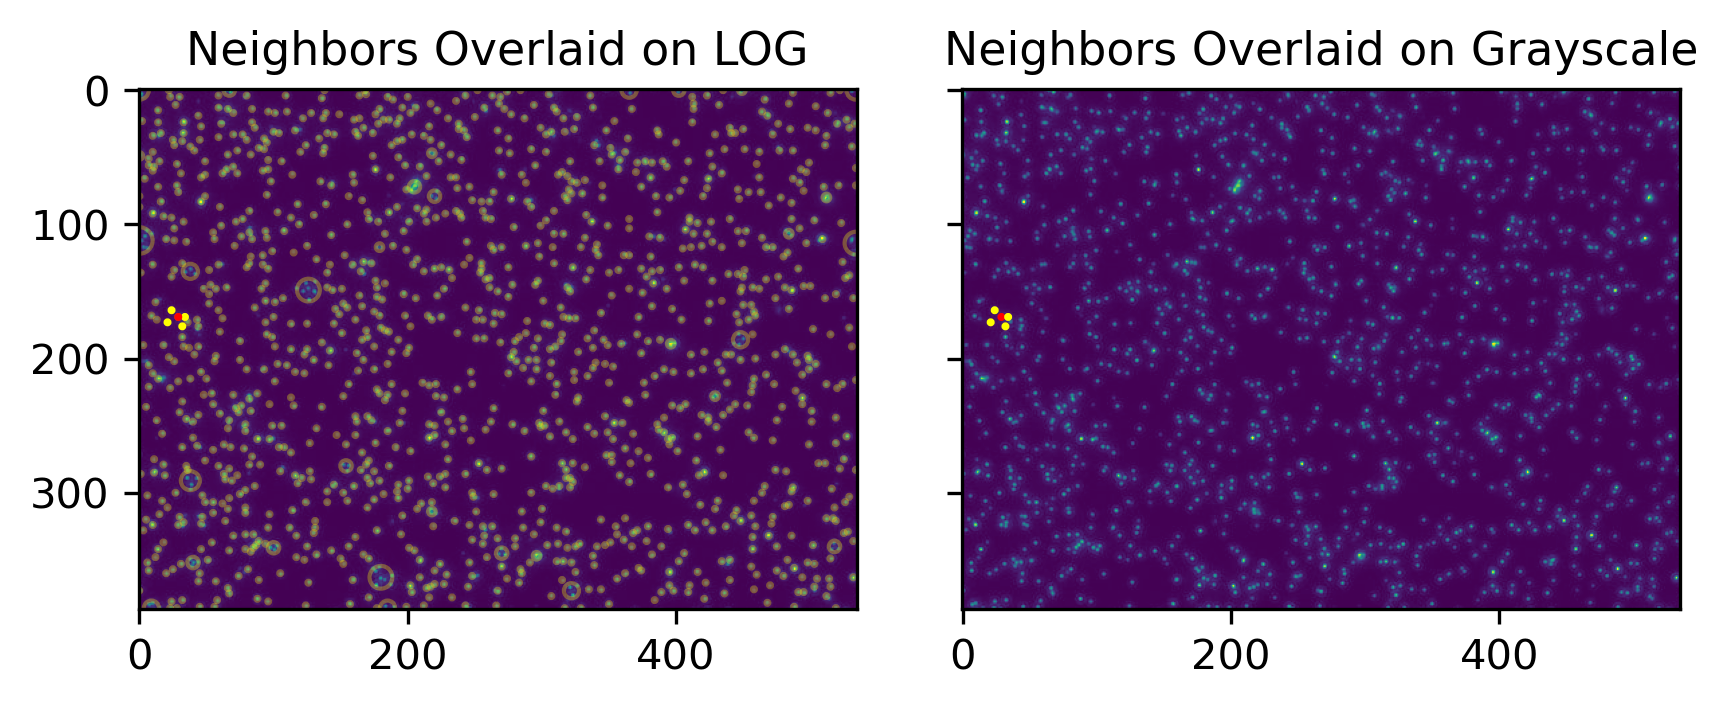

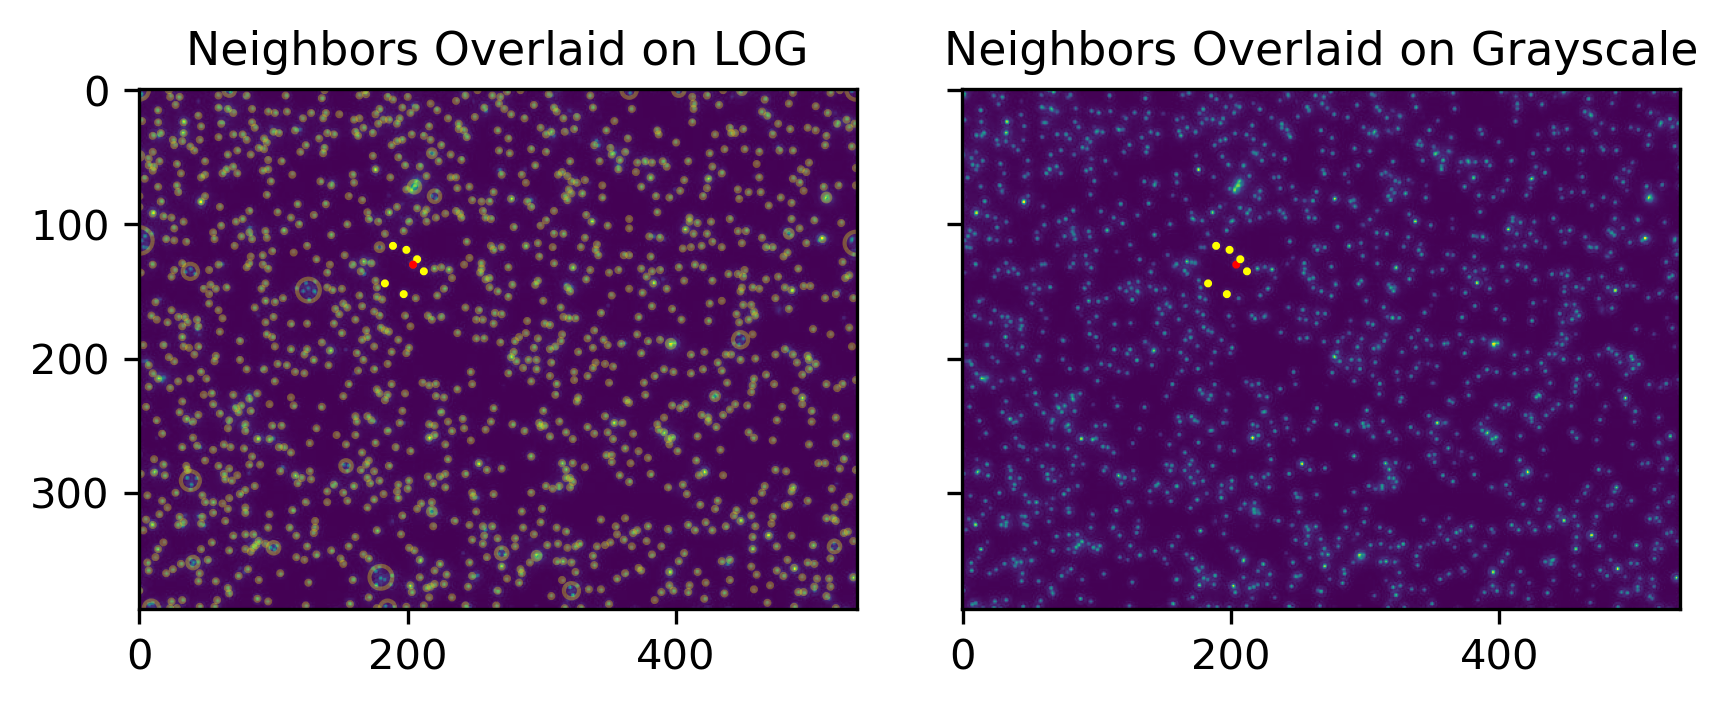

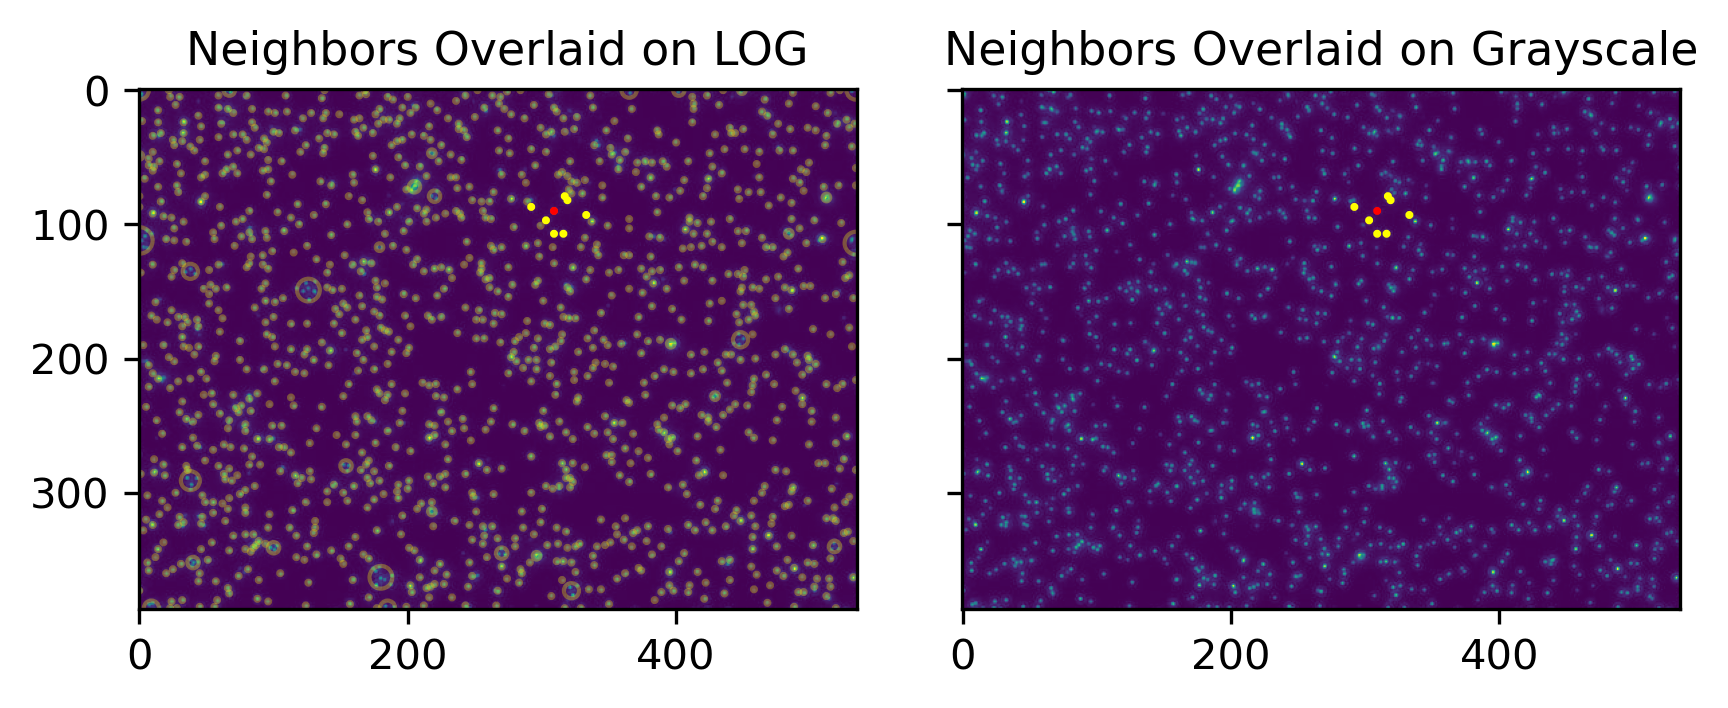

In [14]:
# Visualize Examples of identified neighbors
plot_direct_neighbors(image, laplace_coords, plot_examples = 6)

The euclidean_distance is defined as the length of the hypotenuse between 2 points. 

In [15]:
def euclidean_distance(p1,p2):
    """Calculates Euclidean distance between two points."""
    
    x1,y1 = p1
    x2,y2 = p2
    return hypot(x2 - x1, y2 - y1)

Here we extract the euclidean distance between all points and their direct neighbors. 

A max_distance of 100 pixels is implemented to avoid unrealistic large spacing between points on the edge of the image. Examples of long edge lengths are seen above in the plot showing all points in Delaunay Tessellation. 

The 'scale_bar' argument allows the units of distance to be changed, using an input of distance/pixels. A default of 1 keeps the distance unit in pixels. 

In [16]:
def direct_neighbor_distance(laplace_coords, max_distance = 100, scale_bar = 1):
    """Creates list of euclidean distances between points, only considering direct neighbors found with Delaunay tessellation. 
        Max_distance = 100 pixels to avoid non-representative large spacing on edge of image.
        Optional scale_bar in units of: distance (um) / pixel : (Converts distance unit)"""


    #re-instantiate Delaunay Tessellation
    dela = scipy.spatial.Delaunay
    triang = dela(column(laplace_coords, [0 , 1])) #

    #Find euclidean distance to neighbors. 
    distances = []
    for index in range(len(laplace_coords)):
        
        center_coords = tuple(laplace_coords[index][:2])
        neighbors = laplace_coords[find_neighbors(index, triang)]
    
    
        #Find Euclidean distances
        for neighbor in neighbors:
            
            neighbor_coords = tuple(neighbor[:2])
            neighbor_distance = euclidean_distance(center_coords, neighbor_coords)
            
            if neighbor_distance < max_distance: #implement max_distance for edge of image examples
                distances.append(neighbor_distance)
            else:
                continue
            
    if scale_bar: 
        distances = [x * scale_bar for x in distances]
            
    return distances


In [17]:
# Extract list of distances between direct neighbors only.
distances = direct_neighbor_distance(laplace_coords, max_distance = 100)


Lastly, we summarize the euclidean distance between neighbors as a histogram. The distribution's mean, median, and standard deviation are annotated as text on the plot. 

The same 'scale_bar' argument is required to approriately scale the axes of the plot. 

The 'scale_bar_unit' argument allows labeleing the x-axis with the appropriate distance unit used for conversion. 

In [18]:
def plot_neighbor_histogram(distances, scale_bar = 1, scale_bar_unit = "Pixels"):
    """Plots histogram of euclidean distance between neighbors. Overlays Mean, Median, Std on plot.
        Optional scale_bar in units of: distance (um) / pixel : Included to scale location of text on plot."""
    
    #Plot
    with warnings.catch_warnings(): #Ignore warnings given by 'blob_log'
        warnings.simplefilter("ignore")

        sns.distplot(distances, norm_hist = True)

        plt.title("Euclidean Distance of Direct Neighbors")
        plt.xlabel("Euclidean Distance / " + str(scale_bar_unit))
        plt.ylabel("Density")

        #Overlay mean, median, std as immediate readout. Else could output in txt. 
        plt.text(60 * scale_bar, 0.05 / scale_bar, "Mean = " + str(round(float(np.mean(distances)), 1)))
        plt.text(60 * scale_bar, 0.045 / scale_bar, "Median = " + str(round(float(np.median(distances)), 1)))
        plt.text(60 * scale_bar, 0.04 / scale_bar, "Stdev = " + str(round(float(np.std(distances)), 1)))

        plt.show()
    


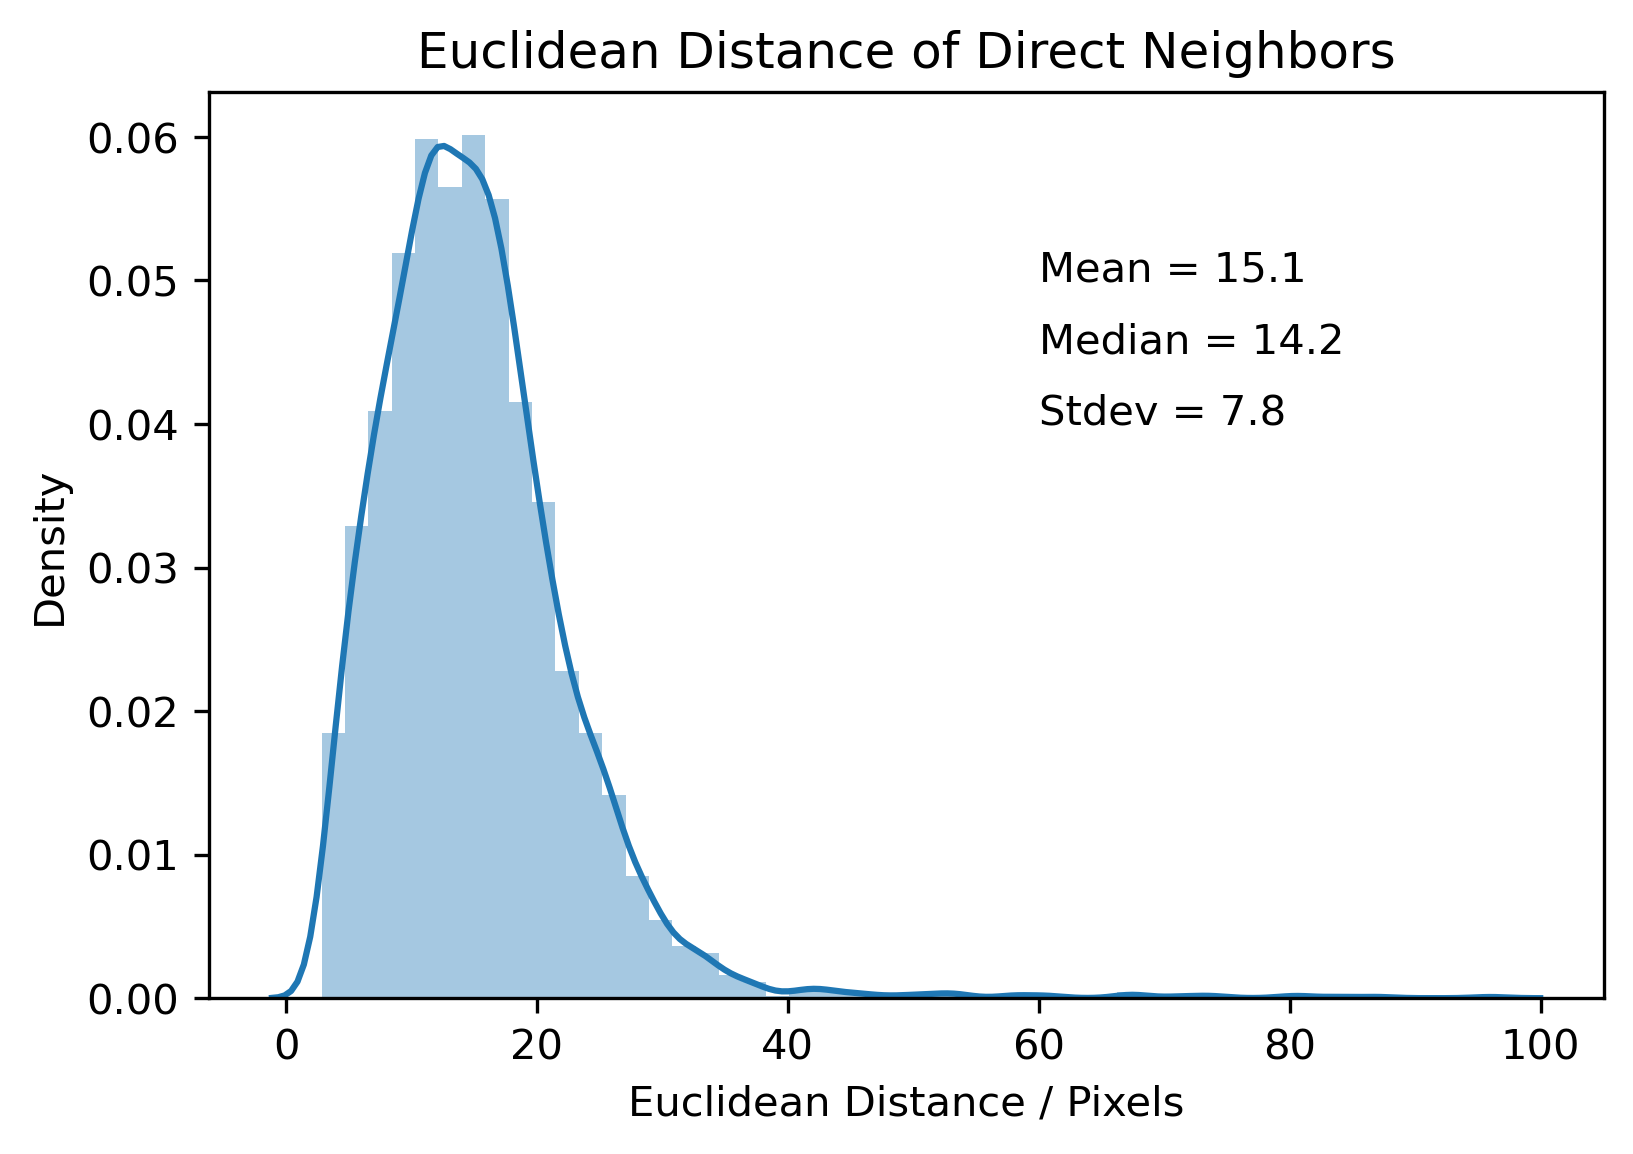

In [19]:
# Plot histogram of neighboring Euclidean distances
plot_neighbor_histogram(distances)



That's it! The resulting distribution gives a clear summary of the interparticle spacing, calculated in a scalable and automated way. Gone is the need to spend hours per image using a ruler to find the same result. Enjoy!

Completed February 21, 2021. 

Peter Defnet